In [9]:
import torch
import torchvision.models as models
from torchinfo import summary

vit_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
summary(vit_model, input_size=(1, 3, 224, 224), device="cpu")


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

Train Epoch: 1 [3168/50000 (6%)]	Loss: 1.914104
Train Epoch: 1 [6368/50000 (13%)]	Loss: 1.702187
Train Epoch: 1 [9568/50000 (19%)]	Loss: 1.585518
Train Epoch: 1 [12768/50000 (26%)]	Loss: 1.187540
Train Epoch: 1 [15968/50000 (32%)]	Loss: 1.027780
Train Epoch: 1 [19168/50000 (38%)]	Loss: 0.650205
Train Epoch: 1 [22368/50000 (45%)]	Loss: 0.799643
Train Epoch: 1 [25568/50000 (51%)]	Loss: 0.752716
Train Epoch: 1 [28768/50000 (58%)]	Loss: 0.386828
Train Epoch: 1 [31968/50000 (64%)]	Loss: 0.317661
Train Epoch: 1 [35168/50000 (70%)]	Loss: 0.550611
Train Epoch: 1 [38368/50000 (77%)]	Loss: 0.292989
Train Epoch: 1 [41568/50000 (83%)]	Loss: 0.303497
Train Epoch: 1 [44768/50000 (90%)]	Loss: 0.170855
Train Epoch: 1 [47968/50000 (96%)]	Loss: 0.302989

Train set: Average loss: 1257.1198, Accuracy: 35775/50000 (72%)
Test set: Average loss: 120.3997, Accuracy: 8677/10000 (87%)

Train Epoch: 2 [3168/50000 (6%)]	Loss: 0.227780
Train Epoch: 2 [6368/50000 (13%)]	Loss: 0.571795
Train Epoch: 2 [9568/50000 (19

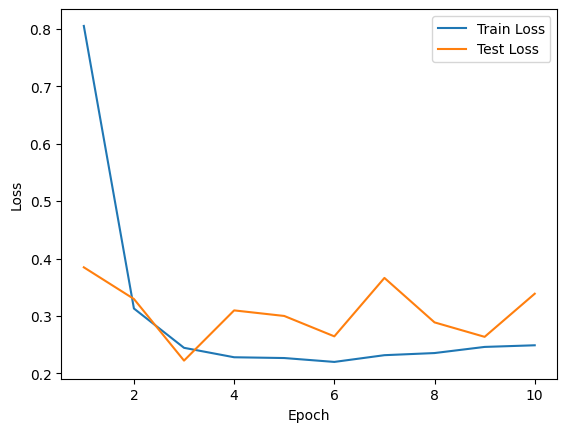

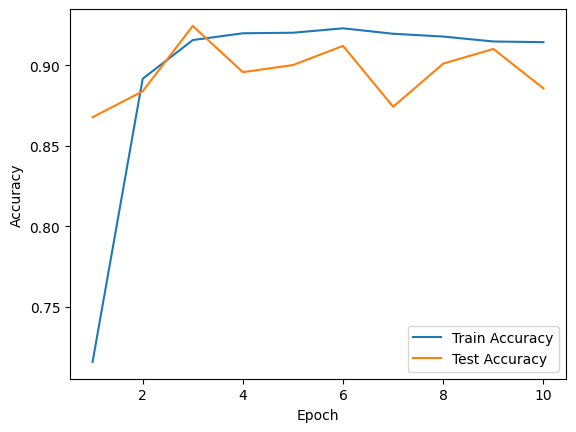

In [11]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

vit_model = models.vit_b_16(weights=models.ViT_B_16_Weights)

number_classes = 10
num_epochs = 10
lr_start = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model.heads[0] = nn.Linear(vit_model.heads[0].in_features, number_classes)

vit_model = vit_model.to(device)

# 对训练数据实现数据增强方法，以便提升模型的泛化能力.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
trainset = torchvision.datasets.CIFAR10(root='../data/', train=True, download=False, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='../data', train=False,download=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(vit_model.parameters()) , lr=lr_start, momentum=0.9, weight_decay=5e-4)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 使用Vit进行训练
        outputs_vit = model(images)
        loss_vit = criterion(outputs_vit, labels)
        optimizer.zero_grad()
        loss_vit.backward()
        optimizer.step()
        train_loss += loss_vit.item()
        _, predicted = torch.max(outputs_vit.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if(i+1)%100 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss_vit.item()))
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))    
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item() # 将一批的损失相加
            _, predicted = torch.max(output.data, 1) # 找到概率最大的下标
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / total)
 
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(vit_model, device, train_loader, optimizer, epoch)
    test(vit_model, device, test_loader)

# 可视化    
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()